# Torch Basics

Yihui "Ray" Ren 
yren@bnl.gov

## Introduction
In this tutorial, you will learn the bolts and nuts of PyTorch. From the basics such as `torch.Tensor`, to something unique for deep learning packages such as `autograd` and `torch.Module`. If we have more time, we will give it a try on using GPUs with PyTorch and demostrate how fast and how easy it is.

The goal of this tutorial is to teach you the basics of PyTorch, rather than some fancy deep learning models, which you will learn in later tutorials. So, let's keep the ML model simple, and see how you can implement the same model, a linear regression model, in different ways as you learn each feature of PyTorch. In the same sprit of simplicity, we are not worrying about train validation split in this tutorial.

## TOC:

* Vectorized Computation
    - numpy torch interchangable API
    - simple linear regression in numpy and torch
* AutoGrad (Automatic Differentiation)
    - torch tensor, backward and `grad` 
    - autograd demo
    - `torch.Module` and `forward`.
    - re-write linear regression in `torch.Module`
* Handling Data 
    - Stochastic Gradient Descent (SGD)
    - `torch.DataSet`
    - `torch.DataLoader`
    - re-re-write linear regression in `torch.Linear`

In [ ]:
## load modules
import time
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

!date +%D
for pkg in ["np", "pd", "torch"]:
    print(f"{pkg:<6} ver: {eval(pkg).__version__}")

# as of last test 12/13/21
# np     ver: 1.20.3
# pd     ver: 1.3.3
# torch  ver: 1.9.1

In [ ]:
# some boilplate functions for display

def line_breaker(foo=None):
    return f"""{"="*30}{foo if foo else "="*20:^20}{"="*30}"""

def eval_expr(expr):
    try:
        print(expr, ":", eval(expr))
    except Exception as e:
        print(expr, "failed because:", e)

def plt_linear_fit(x, y, yhat, a, b):
    """
        x, y: input and groud truth
        yhat: prediction
        a, b: parameters of linear model
    """
    fig, axes = plt.subplots(1,2,figsize=(8,4), sharey=True)
    ax1, ax2 = axes
    ax1.scatter(x, y, facecolor='none', edgecolor='b', alpha=0.1)
    ax1.plot(np.linspace(0, 30), a*np.linspace(0,30)+b, 'r')
    ax1.set_title(f"a={a:.3E}, b={b:.3E}")
    ax1.set_xlim([0,30])
    ax1.set_ylim([0.985,1.01])
    ax1.set_ylabel("ground truth y")
    ax1.set_xlabel(" x ")
    ax2.scatter(yhat, y, facecolor='none', edgecolor='b', alpha=0.1)
    # ax2.set_title(f"MAE = {np.abs(y-yhat).mean():.3E}")
    ax2.set_title(f"$R^2$ = {1-np.power(y-yhat, 2).sum()/np.power(y-y.mean(),2).sum():.3}")
    ax2.set_ylim([0.985,1.01])
    ax2.set_xlim([0.985,1.01])
    ax2.set_xlabel("yhat")
    return fig
    

## Vectorized Computation
As for tensor calculation, PyTorch is very similar to numpy. Many functions are very similar. There are blog posts comparing the two, such as [this](https://jhui.github.io/2018/02/09/PyTorch-Basic-operations/) and [that](https://rickwierenga.com/blog/machine%20learning/numpy-vs-pytorch-linalg.html). I will use array, ndarray and tensor interchangibly. If you missed the numpy tutorial, please refer to `001_NumPy.ipynb`.

* Array Creation and Converting between Numpy and PyTorch
* Tensor Operation: add, multiply, elementwise multiply, and so on 


In [ ]:
# Array Creation
some_shape = (5,3)
some_list = [5,3,2,1]
def compare_numpy_torch(np_cb, th_cb, some):
    x = np_cb(some)
    y = th_cb(some)
    x, y = x.shape, y.shape
    return x, y

for func in ["empty", "ones", "zeros"]:
    print(line_breaker("comparing "+func))
    npf, thf = eval("np."+func), eval("torch."+func)
    print(compare_numpy_torch(npf, thf, some_shape))

# random tensor
print(line_breaker("comparing "+"rand"))
x = np.random.rand(*some_shape) # np rand does not take a tuple for shape
y = torch.rand(some_shape)
print(x.shape, y.shape)

## change random seed, get and set state
np.random.seed(5)
rng_state = np.random.get_state()
np.random.set_state(rng_state)

torch.random.manual_seed(5)
rng_state = torch.random.get_rng_state()
torch.random.set_rng_state(rng_state)

# convert between numpy and torch
print(line_breaker("convert btwn np and torch"))
x = np.random.rand(2,2)
y = torch.tensor(x) # convert np to torch
z = y.numpy() # convert torch to np
assert (x == z).all()

In [ ]:
## matrix operation
def init_two_mat(shape):
    op = "init"
    print(line_breaker(op))
    npx = np.random.rand(*shape)
    thx = torch.tensor(npx)
    # print("x:",npx)
    return npx, thx

x_shape = (3, 3)
y_shape = (3, 3)
npx, thx = init_two_mat(x_shape)
npy, thy = init_two_mat(y_shape)

### add 
op = "add"
print(line_breaker(op))
npz = npx + npy
thz = thx + thy
print("x+y=z:", npz)
assert (npz == thz.numpy()).all()

### elementwise mult aka Hadamard product
op = "elementwise multi"
print(f"""{"="*30}{op:^20}{"="*30}""")
npz = npx*npy
thz = thx*thy
print("x*y=z:", npz)
assert np.isclose(npz, thz.numpy()).all()

In [ ]:
### mat product (nxp) x (pxm) -> (nxm)

x_shape = (3, 4)
y_shape = (4, 3)
npx, thx = init_two_mat(x_shape)
npy, thy = init_two_mat(y_shape)

op = "multiply"
print(f"""{"="*30}{op:^20}{"="*30}""")
npz = npx@npy
thz = thx@thy
print("x@y=z:", npz)
assert np.isclose(npz, thz.numpy()).all()
# alternatively 
npz = npx.dot(npy) # avoid using this function for its confusing name
thz = thx.mm(thy) # only works for matrices
print("x.mm(y)=z:", npz)
assert np.isclose(npz, thz.numpy()).all()
# operator launched by package name.
npz = np.matmul(npx,npy)
thz = torch.matmul(thx, thy) 
print("pkg.mm(x, y)=z:", npz)
assert np.isclose(npz, thz.numpy()).all()

### matmul also works for batched matrix mult 
npx, thx = init_two_mat((3, 1, 4, 5))
npy, thy = init_two_mat((6, 5, 7))
npz = np.matmul(thx, thy)
thz = torch.matmul(thx, thy) 
print("thz shape", thz.shape)
assert np.isclose(npz, thz.numpy()).all()
assert thz.shape == (3,6,4,7)

### will mm, dot, and "@" will  work ?
eval_expr("npx.dot(npy).shape") # works in strange way
eval_expr("(npx@npy).shape") # works as matmul
eval_expr("(thx@thy).shape") # works as matmul 
eval_expr("thx.mm(thy).shape") # cant, must be a matrix

In [ ]:
## Tensor Dimension Manipulations
def create_test_tensors(x_shape):
    npx = np.random.rand(*x_shape)
    thx = torch.tensor(npx)
    return npx, thx
    
### transpose
op = "transpose"
print(line_breaker(op))

tensor_shape = (1,3)
npx, thx = create_test_tensors(tensor_shape)
npxT = npx.T
thxT = thx.T

tensor_shape = (3,4,5,6)
#  dim idx     (0,1,2,3)
new_order = "(1,0,3,2)"
#  dim sz    (4,3,6,5)
npx, thx = create_test_tensors(tensor_shape)
print("before transpose", npx.shape, thx.shape)
eval_expr(f"np.transpose(npx, {new_order}).shape")
eval_expr(f"npx.transpose({new_order}).shape")
eval_expr(f"thx.permute({new_order}).shape") 
eval_expr(f"torch.permute(thx, {new_order}).shape")

# .T will simply reverse the dim order  -> (6,5,4,3)
eval_expr("npx.T.shape")
eval_expr("thx.T.shape")


### flatten and reshape 
op = "flatten"
print(line_breaker(op))
tensor_shape = (3,4,5)
npx, thx = create_test_tensors(tensor_shape)
npflat1 = npx.reshape(-1)
npflat2 = npx.flatten()
thflat1 = thx.reshape(-1)
thflat2 = thx.flatten()
thflat3 = thx.view(-1)
thflat4 = torch.flatten(thx)
for x in [npflat1, npflat2, thflat1, thflat2, thflat3, thflat4]:
    print(x.shape)

In [ ]:
### Squeeze and Unsqueeze (adding and removing dummy dimensions)
op = "squeeze"
print(line_breaker(op))
tensor_shape = (3,1,5)
npx, thx = create_test_tensors(tensor_shape)
print("before squeeze", npx.shape, thx.shape)
npxs = npx.squeeze()
thxs = thx.squeeze() 
print("after squeeze ", npxs.shape, thxs.shape)

op = "unsqueeze"
print(line_breaker(op))
npxus = np.expand_dims(npxs,1)
thxus = thxs.unsqueeze(1)
print("after unsqueeze at dim 1:", npxus.shape, thxus.shape)

### Concat 
op = "concatenate"
print(line_breaker(op))
tensor_shape = (3,5)
npx, thx = create_test_tensors(tensor_shape)
npy, thy = create_test_tensors(tensor_shape)
print("before concat", npx.shape, npy.shape)
npz0 = np.concatenate((npx, npy), axis=0)
thz0 = torch.cat((thx, thy), axis=0)
assert npz0.shape == thz0.shape
print("after concat along dim 0:", npz0.shape)
npz1 = np.concatenate((npx, npy), axis=1)
thz1 = torch.cat((thx, thy), axis=1)
assert npz1.shape == thz1.shape
print("after concat along dim 1:", npz1.shape)

## Linear Regression Using Vectorized Computation

* Wine Quality Dataset
* Linear regression using a formula
* Homework: convert numpy implementation to torch


In [ ]:
## get data for linear regression. 
## find the most correlated two features for linear regression. 
wine_quality_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
df = pd.read_csv(wine_quality_url, delimiter=";")
w = df.corr()
up_tri = np.triu(np.abs(w.to_numpy()),k=1)
max_idx = np.argmax(up_tri)
col_sz = len(df.columns)
col1, col2 = df.columns[max_idx//col_sz], df.columns[max_idx%col_sz]
# print(max_idx,up_tri.flatten()[max_idx], col1, col2)
print(f"""found "{col1}" and "{col2}" for linear regression""") # most correlated two features

fig, axes = plt.subplots(1,2,figsize=(10,4))
htm = sns.heatmap(w, ax=axes[0])
htm.set_xticklabels(htm.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.scatterplot(x=df[col1], y=df[col2], ax=axes[1])
axes[1].set_title(f"{col1} and {col2} \n corr.coef. = {np.corrcoef(df[col1], df[col2])[0,1]:.4f}")

wine_x, wine_y = df[col1].to_numpy(), df[col2].to_numpy()

### Simple Linear Regression 
Find a and b such that:
$\sum (y-y')^2$
is minimized, where
$y' = ax+b$

$a$ and $b$ are your linear model parameters.

with solution 

$a = \sum(x - \bar{x})(y - \bar{y}) / \sum (x - \bar{x})^2$

$b = \bar{y} - a\bar{x}$


In [ ]:
# %%timeit -n10 -r10
## here is a numpy implementation
xbar = np.mean(wine_x)
ybar = np.mean(wine_y)
a = (wine_x - xbar)@(wine_y-ybar).T / np.power(wine_x-xbar, 2).sum()
b = ybar - a * xbar

In [ ]:
plt_linear_fit(wine_x, wine_y, a*wine_x+b, a, b);

### Exercise: re-write above code in torch
here is the torch doc https://pytorch.org/docs/stable/torch.html

In [ ]:
thx = torch.tensor(wine_x)
thy = torch.tensor(wine_y)
##                            ##
##                            ##
##  Intentionally Left Blank  ## 
##                            ##
##                            ##

In [ ]:
# %%timeit -n10 -r10
## Solution
## comparing to the numpy implementation line by line, do you spot any difference?
thx = torch.tensor(wine_x)
thy = torch.tensor(wine_y)
xbar = torch.mean(thx)
ybar = torch.mean(thy)
a = (thx - xbar)@(thy-ybar).T / torch.pow(thx-xbar, 2).sum()
b = ybar - a * xbar

In [ ]:
plt_linear_fit(wine_x, wine_y, (a*thx+b).numpy(), a.numpy(), b.numpy());

## AutoGrad
In this section, you will learn automated differentiation.
1. Torch tensor has built-in grad
    - `x.data`
    - `x.grad`
    - `x.backward()`
2. Wrap tensors and operations into `nn.Module` so they are chained 
    - `nn.Module`
    - `forward()`
    - `torch.Parameter()`
3. Revisit Linear Model   
    - `nn.Linear`
    - Gradiant Descent
   

### Torch Tensor Autograd
image credit: https://datahacker.rs/004-computational-graph-and-autograd-with-pytorch/
![image](https://media5.datahacker.rs/2021/01/11-1024x593.jpg)

In [ ]:
## y = a*x, dy/dx = ? 
x = torch.tensor(0.1, requires_grad=True)
a = torch.tensor(3) # not requires grad
y = a*x # y=ax, dy/dx = a
y.backward()
print("variable x", x.data, "has grad of", x.grad)
# what is a.grad ? will it still work if `a = 3`?

In [ ]:
## here is another example
## y = exp(a*x), dy/dx = ? 
## see if this is what you expected.
x = torch.tensor(0.3, requires_grad=True)
a = torch.tensor(3)
y = torch.exp(a*x) 
# do it by hand using chain rule: 
# y = exp(ax), dy/dx = exp(ax) d(ax)/dx = a * exp(ax) 
print("do it by hand:\n", "y = exp(ax), dy/dx = exp(ax) d(ax)/dx = a * exp(ax)")
print("before backward(), x grad is: ", x.grad)
y.backward()
print("variable x", x, "has grad of", x.grad, "which should be the same as", a*torch.exp(a*x).detach())
## Bonus question: what if you backward() again? and why

In [ ]:
## Exercise: pick a f(x) you like, and autograd it!  


In [ ]:
##                            ##
##                            ##
##  Intentionally Left Blank  ## 
##                            ##
##                            ##

Let's consider this function: $ y = ( \sin x + 1 )^x $

In [ ]:
## Solution:  
## ok, another example y = (sin(x)+1)^x 
print("for example y = (sin(x)+1)^x")
x = torch.tensor(0.2, requires_grad=True)
y = (torch.sin(x)+1).pow(x)
y.backward()
ans = torch.exp(x*torch.log(torch.sin(x)+1))*((torch.log(torch.sin(x)+1))+x*(torch.sin(x)+1).pow(-1)*torch.cos(x))
print(x, x.grad, ans)

## summary: autograd works like a charm
## bonus: see how you can define your own auto-grad function that is not obviously defirentiable:
##  https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html#pytorch-defining-new-autograd-functions

In [ ]:
## Torch Module 
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html
# torch.module: Packing parameters and functions together
# motivations: for each composition and recursive "apply"
# two APIs:
# __init__() and forward()

class TenFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.x = torch.tensor(0.2, requires_grad=True) 
        
    def forward(self):
        # from above exapmle y = (sin(x)+1)^x 
        # usually forward takes an input, omit it for now.
        return (self.x.sin()+1).pow(self.x)
    
## create a module 
func = TenFunc()
y = func()
y.backward()
print(func.x.grad)

In [ ]:
## Error: if requires_grad=False
print("Warning: this will produce error")
class FuncError(nn.Module):
    def __init__(self):
        super().__init__()
        self.x = torch.tensor(0.2) 
        
    def forward(self):
        return (self.x.sin()+1).pow(self.x)
    
## create a module 
func = FuncError()
y = func()
try:
    y.backward()
except RuntimeError as err:
    print(err)
    
print("func.x.grad is", func.x.grad)


In [ ]:
## Better to use torch.nn.Parameter
## and rename x as w (as weights) as a convention.

class ParaFunc(nn.Module):
    def __init__(self):
        super().__init__()
        w = torch.tensor(0.2)
        self.w = nn.Parameter(w)
        
    def forward(self, input):
        return (self.w.sin()+1).pow(self.w)
    
## create a module 
func = ParaFunc()
y = func(None)
y.backward()
print(func.w.grad)

In [ ]:
## [Optional] (requires GPU)
## The benefits of using Parameter are two folds: 
#  * registered to module parameters. 
#  * moves with modules to device.

print(line_breaker())
print("nn.Parameters are registered to nn.Module")
func = ParaFunc()
for p in func.parameters():
    print(p)
    
print(line_breaker())
print("torch.tensor was not registered")
func = TenFunc()
for p in func.parameters():
    print(p)
print("got nothing")
print(line_breaker())

if torch.cuda.is_available():
    print(line_breaker("move btwn cpu&gpu"))
    print("registered parameter moves with Module")
    func_p = ParaFunc()
    print(f"before move: \t{func_p.w.device}")
    # also works on GPU
    func_p = func_p.cuda()
    print(f"after move: \t{func_p.w.device}")
    
    print("unregistered tensor does not")
    # if Func tensor
    func_t = TenFunc()
    print(f"before move: \t{func_t.x.device}")
    # also works on GPU
    func_t = func_t.cuda()
    print(f"after move: \t{func_t.x.device}")
    
    ## print out:
    #  cpu
    #  cuda:0
    #  cpu
    #  cpu

### Module Composition
Modules can be composed together or called in sequence, auto-grad will work in both cases.
Let's still use this function: $ y = ( \sin x + 1 )^x $, and break it into two simpler ones $\sin(x)$ and $u^x$

In [ ]:
## Modules can be composed and auto grad works 
## let's break the previous function into two parts, 
class SinFunc(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input):
        return torch.sin(input)
    
class PowFunc(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input, x):
        return torch.pow(input, x)

In [ ]:
x = torch.tensor(0.2, requires_grad=True)
f = SinFunc()
g = PowFunc()
y = g(f(x)+1, x)
y.backward()
x.grad  # recall the correct answer is tensor(0.3575)

In [ ]:
class CombineFunc(nn.Module):
    def __init__(self):
        super().__init__()
        # Modules within Module
        self.f = SinFunc()
        self.g = PowFunc()
    def forward(self, x):
        return self.g(self.f(x)+1, x)
h = CombineFunc()
x = torch.tensor(0.2, requires_grad=True)

In [ ]:
y = h(x)
y.backward()
x.grad
# what's the value of x.grad? why is it? what if you run several times?

### Revisit Linear Model
Let's get back to the linear regression model. We can solve it another way using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent): $a_{n+1} = a_n - \gamma \nabla F(a_n)$
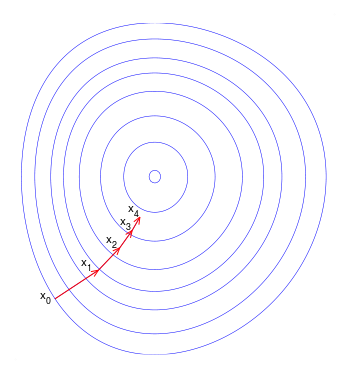!

In [ ]:
class MyLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        torch.random.manual_seed(7) 
        # some random guess of initial values
        self.a = nn.Parameter(torch.rand(1), requires_grad=True) 
        self.b = nn.Parameter(torch.rand(1), requires_grad=True)
    
    def forward(self, x):
        return x*self.a + self.b

In [ ]:
thx = torch.tensor(wine_x)
thy = torch.tensor(wine_y)
lin = MyLinearModel()
yhat = lin(thx)
V = lambda x: x.cpu().detach().squeeze().numpy()  #  tensor to numpy for easy plotting

In [ ]:
lr = 0.003 # learning rate \gamma
num_epochs = 10**4
for ep in range(num_epochs):
    yhat = lin(thx)
    loss = ((thy-yhat)*(thy-yhat)).mean()
    loss.backward()
    for p in lin.parameters():
        # Q: what is p? 
        p.data -= lr * p.grad
        p.grad.zero_() 
        # Q: recall why we need to set grad to zero?
    
    if ep%10**3==0:
        clear_output()
        plt.close(fig)
        fig = plt_linear_fit(wine_x, wine_y, V(lin(thx)), V(lin.a), V(lin.b))
        display(fig)
        time.sleep(1)

for name, p in lin.named_parameters():
    print(name, "has value", p.data)

## bonous: learning rate and number of epochs are chosen for you in this example. 
##         They are called "Hyper-parameters"
##         Try to change their values, and explain how they impact the learning process.

## Handling Data

In most cases, we are facing a very large dataset and a very large model. So large that an ordinary memory will not fit everything. SGD treats a random subset of the dataset as an "entire dataset" for one GD step. Such random subset at every step is called "mini batch"

- Stochastic Gradient Descent (SGD)
- `torch.DataSet`
- `torch.DataLoader`
- `torch.nn.MSELoss`
- `torch.optim.SGD`
- `torch.nn.Linear` 


### `torch.Dataset`
`Dataset` has two API: `__getitem__` and `__len__`
if you are a veteran of python, you know they give your 
class object x `x[idx]` operator  and 
`len(x)` to query the total size.

now, let's pack our wine dataset into the `Dataset`.


In [ ]:
from torch.utils.data import Dataset, DataLoader
class WineData(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.single)
        self.y = y.astype(np.single)
        assert len(self.x) == len(self.y)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)

# usage example:
dataset = WineData(wine_x, wine_y)
print("data sz = ", len(dataset))
print("get the 3rd item",dataset[2])

### DataLoader

`DataLoader` wraps data into a generator. (`__iter__` and `__next__`)
One can iterate the dataset subset by subset of `batch_size`.
At the end of iteration, the sequence of data is shullfled ("stochastic"), if one sets `shuffle=True`.
It also provides a way to split the data loading workload among multiple CPU workers via `num_workers=4`.
This will be useful when each data point is very large and requires expensive pre-processing.

read more: https://pytorch.org/docs/stable/data.html

In [ ]:
## some use examples:
dataset = WineData(wine_x, wine_y)
dataloader = DataLoader(dataset, batch_size=4, drop_last=True, shuffle=True)
print(next(iter(dataloader))) 
# notice that x and y are grouped together, 
# as x will go through the model, and y will be used in the loss function

# next minibatch
x, y  = next(iter(dataloader))
print(x.data)
print(y.data)

for (x, y), i in zip(dataloader, range(5)):
    print(i,":",x.data,y.data)

### Loss Function
The loss function is usually the last numeric operation in
the computation graph. It calculates how far the current
model from the target (ground truth). There are many common
loss functions built-in in the PyTorch. And it is not so
difficult to write your own, since under the hood, they are
nothing but `nn.Module`s. 

read more on loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions

In [ ]:
## recall our loss function is (y-yhat)^2, this is called mean squared error or MSE
## note `thy` and `yhat` from previous linear model, one should see very small loss
loss_fn = torch.nn.MSELoss()
prev_loss_fn = ((thy-yhat)*(thy-yhat)).mean()
print(loss_fn(thy,yhat))
print(prev_loss_fn)

### SGD

SGD is part of PyTorch Optimizer package: `torch.optim`. To initialize an optimizer, we need to pass the parameters of the model and some hyper-parameters such as learning rate.

The optimizer, say `optmzr`, does two things: 
- `optmzr.zero_grad()` sets all parameters' gradients to 
   zero (recall `recursive apply` and why we use `nn.Module`), and
- `optmzr.step()` to adjust all parameters `.data` by the amoung of
   `.grad` weighted by the step size (or learning rate in the case of SGD).

SGD is the most classic learning algorithm where the step size is fixed and determined by the learning rate. There are many more advanced learning algorithms that the step size is adjusted on the fly.

read more: https://pytorch.org/docs/stable/optim.html

In [ ]:
## usage example
model = MyLinearModel()
optim = torch.optim.SGD(model.parameters(), lr=0.5)
model.a.grad = torch.tensor([0.5]) ## let's manuall set grad of a to 0.5
print(model.a.data, model.a.grad)
optim.zero_grad()
print("after zero_grad", model.a.data, model.a.grad)

model.a.grad = torch.tensor([0.4]) ## let's manuall set grad of a to 0.4
print(model.a.data, model.a.grad)
optim.step() # Question, what is the value `model.a.data`? lr=0.5, grad=0.4
print(model.a.data, model.a.grad)

### `nn.Linear`

PyTorch has many neural network models and model components. `nn.Linear` is exactly our linear model.
Recall that a linear model is nothing but $ax+b$ where $a$ is called weight and $b$ is called bias.
To initialize a `Linear` model, we simply put the `in_features` and `out_features`.

- `nn.Linear(in_features=3, out_features=5)` will result a weight matrix (5x3), 
- `model.weight` and `model.bias` to access the model's weight and bias


read more: https://pytorch.org/docs/stable/nn.html

In [ ]:
model = nn.Linear(3,5)
print(model.weight)
print(model.bias)

### Putting Everything Together

1. dataset
1. dataloader
1. loss function
1. model
1. optimizer
1. train in a for loop




In [ ]:
dataset = WineData(wine_x, wine_y)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)
loss_fn = nn.MSELoss()
model = nn.Linear(1,1)
optmzr = torch.optim.SGD(model.parameters(), lr=0.003)
num_epochs = 1000
for e in range(num_epochs):
    for x, y in dataloader:
        x, y = x.unsqueeze(1), y.unsqueeze(1)
        yhat = model(x)
        loss = loss_fn(y, yhat)
        
        # update the weights
        optmzr.zero_grad()
        loss.backward()
        optmzr.step()
    
    if e%100==0:
        clear_output()
        plt.close(fig)
        ypred = model(thx.clone().detach().float().unsqueeze(1))
        fig = plt_linear_fit(wine_x, wine_y, V(ypred), V(model.weight.data), V(model.bias))
        display(fig)
        time.sleep(1)
        
print(model.weight.data, model.bias.data)

Recall our previous gradient descent code, and compare with above SGD code. 
Can you identify the corresponding part of the code?
```
lr = 0.003 # learning rate \gamma
num_epochs = 10**4
for ep in range(num_epochs):
    yhat = lin(thx) 
    loss = ((thy-yhat)*(thy-yhat)).mean()
    loss.backward()
    for p in lin.parameters():
        p.data -= lr * p.grad
        p.grad.zero_() 
```